<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

© Copyright Quantopian Inc.<br>
© Modifications Copyright QuantRocket LLC<br>
Licensed under the [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).<br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Quant Finance Lectures (adapted Quantopian Lectures)](Introduction.ipynb) › Lecture 29 - Universe Selection
***

# Universe Selection

by Gil Wassermann, Maxwell Margenot

<a href="https://youtu.be/oa5RhuHVbH0?t=65" target="_blank">Quantopian video for this lecture ↗</a>

Selecting the product space in which an algorithm trades can be as important as, if not more than, the strategy itself. In this lecture, we will walk through the basics of constructing a universe.

## What is a Universe?

On a high level, universe selection is the process of choosing the pool of securities upon which your algorithm will trade. For example, an algorithm designed to play with the characteristics of a universe consisting of technology equities may perform exceptionally well in that universe with the tradeoff of falling flat in other sectors. Experimenting with different universes by tweaking their components is an essential part of developing a trading strategy.

Using Pipeline and the full US Stock dataset, we have access to over 8000 securities to choose from each day. However, the securities within this basket are markedly different. Some are different asset classes, some belong to different sectors and super-sectors, some employ different business models, some practice different management styles, and so on. By defining a universe, a trader can narrow in on securities with one or more of these attributes in order to craft a strategy that is most effective for that subset of the population.

Without a properly-constructed universe, your algorithm may be exposed to risks that you just aren't aware of. For example, it could be possible that your universe selection methodology only selects a stock basket whose constituents do not trade very often. Let's say that your algorithm wants to place an order of 100,000 shares for a company that only trades 1,000 on a given day. The inability to fill this order or others might prevent you from achieving the optimal weights for your portfolio, thereby undermining your strategy. These risks can be controlled for by careful and thoughtful universe slection.

In Zipline, universes are often implemented as a Pipeline screen. If you are not familiar with Pipeline, feel free to check out the [Pipeline Tutorial](https://www.quantrocket.com/code/?repo=pipeline-tutorial). Below is an example implementation of a universe that limits Pipeline output to the 500 common stocks with the largest dollar volume each day.

In [1]:
import matplotlib.pyplot as plt
from zipline.pipeline import Pipeline, master
from zipline.pipeline.factors import AverageDollarVolume
from zipline.research import run_pipeline

In [2]:
dollar_volume = AverageDollarVolume(window_length=30)

common_stocks = master.SecuritiesMaster.usstock_SecurityType2.latest.eq("Common Stock")

pipe = Pipeline(
    columns={
        'DollarVolume': dollar_volume
    },
    screen=dollar_volume.top(500),
    initial_universe=common_stocks
)
res = run_pipeline(pipe, start_date='2010-01-04', end_date='2010-01-04', bundle='usstock-learn-1d')
print("There are %d assets in this universe." % len(res))

res.head(10) # print 10 constituents 

There are 500 assets in this universe.


DollarVolume
date       asset                                      
2010-01-04 Equity(FIBBG000C2V3D6 [A])     6.945804e+07
           Equity(FIBBG000F7RCJ1 [AAP])   6.165486e+07
           Equity(FIBBG000B9XRY4 [AAPL])  3.443862e+09
           Equity(FIBBG000MDCQC2 [COR])   7.949157e+07
           Equity(FIBBG000B9ZXB4 [ABT])   2.947769e+08
           Equity(FIBBG000DQ1D34 [ACL])   1.158285e+08
           Equity(FIBBG000D9D830 [ACN])   1.610927e+08
           Equity(FIBBG000J8CD72 [ACS])   5.442912e+07
           Equity(FIBBG000BB5006 [ADBE])  1.649604e+08
           Equity(FIBBG000BB6G37 [ADI])   1.133937e+08

This is a good start, but again, it is a very naive universe. High dollar volume indicates liquidity but does not necessarily indicate a healthy, thriving company. There are many other things that play into the construction of a good universe.

For the rest of this notebook, we will design our own universe, profile it and check its performance. Let's create the Lectures500!

## Lectures500

### Sector Exposure

If I create a universe that only looks at equities in the technology sector, my algorithm will have an extreme sector bias. Companies in the same industry sector are affected by similar macroeconomic trends and therefore their performance tends to be correlated. In the case of particular strategies, we may find the benefits of working exclusively within a particular sector greater than the downside risks, but this is not suitable for creating a general-purpose, quality universe.

Let's have a look at the sector breakdown of the Lectures500.

In [3]:
# Rename our universe to Lectures500
Lectures500 = dollar_volume.top(500)

def get_sectors(day, universe, bundle):
    pipe = Pipeline(
        columns={
            'Sector': master.SecuritiesMaster.usstock_Sector.latest
        }, 
        screen=universe, 
        initial_universe=common_stocks
    )
    # Drop the datetime level of the index, since we only have one day of data 
    return run_pipeline(pipe, start_date=day, end_date=day, bundle=bundle).reset_index(level=0, drop=True)


def calculate_sector_counts(sectors):
    counts = (sectors.groupby('Sector').size())
    return counts

lectures500_sectors = get_sectors('2010-01-04', Lectures500, 'usstock-learn-1d')
lectures500_counts = calculate_sector_counts(lectures500_sectors)

In [4]:
def plot_sector_counts(sector_counts):
    
    bar = plt.subplot2grid((10,12), (0,0), rowspan=10, colspan=6)
    pie = plt.subplot2grid((10,12), (0,6), rowspan=10, colspan=6)
    
    # Bar chart
    sector_counts.plot(
        kind='bar',
        color='b',
        rot=30,
        ax=bar,
    )
    
    bar.set_title('Sector Exposure - Counts')
    
    # Pie chart
    sector_counts.plot(
        kind='pie', 
        colormap='Set3', 
        autopct='%.2f %%',
        fontsize=12,
        ax=pie,
    )
    pie.set_ylabel('')  # This overwrites default ylabel, which is None :(
    pie.set_title('Sector Exposure - Proportions')
    
    plt.tight_layout();

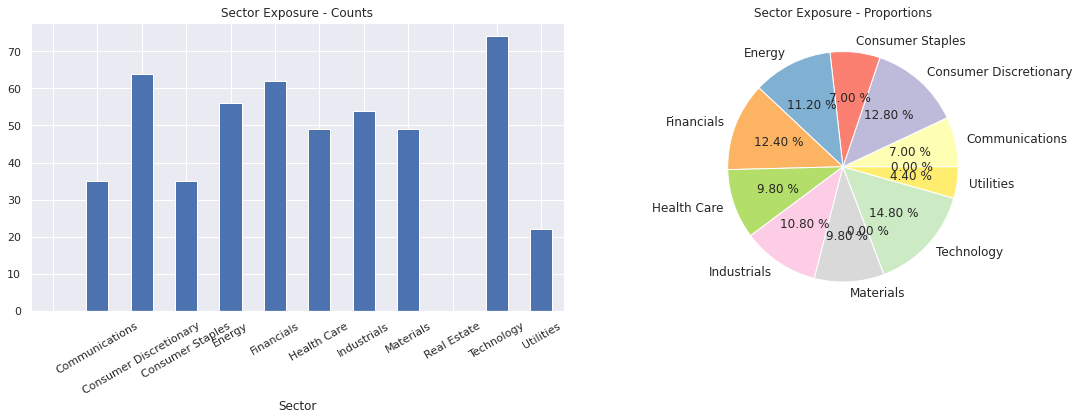

In [5]:
plot_sector_counts(lectures500_counts)

From the above plots it is clear that there is a mild sector bias towards the technology industry. Any big events that affect companies in this sector will have a large effect on this universe and any algorithm that uses it.

One option is to equal-weight the sectors, so that equities from each industry sector make up an identical proportion of the final universe. This, however, comes with its own disadvantages. In a sector-equal Lectures500, the universe would include some lower-dollar-volume utility companies at the expense of higher-dollar-volume technology companies.

### Turnover

Another thing to consider when designing a universe is the rate at which the universe changes. Turnover is a way of measuring this rate of change. Turnover is defined as the number of equities to enter or exit the universe in a particular time window. 

Let us imagine a universe with a turnover of 0. This universe would be completely unchanged by market movements. Moreover, stocks inappropriate for the universe would never be removed and stocks that should be included will never enter.

Conversely, imagine a universe that changes every one of its constituents every day. An algorithm built on this universe will be forced to sell its entire portfolio every day. This incurs transaction costs which erode returns.

When creating a universe, there is an inherent tradeoff between stagnation and sensitivity to the market.

Let's have a look at the turnover for the Lectures500!

In [6]:
res = run_pipeline(
    Pipeline(
        columns={
            'Lectures500' : Lectures500
        },
        initial_universe=common_stocks
    ), start_date='2010-01-01', end_date='2011-01-01', bundle='usstock-learn-1d')

res = res.unstack().fillna(False).astype(int)

def calculate_daily_turnover(unstacked):
    return (unstacked
            .diff()        # Get 1/0 (True/False) showing where values changed from previous day.
            .abs()         # take absolute value so that any turnover is a 1
            .iloc[1:]      # Drop first row, which is meaningless after diff().
            .T
            .groupby(level=0)  
            .sum()
            .T)        # Group by universe and count number of 1 values in each row.

def plot_daily_turnover(unstacked):
    
    # Calculate locations where the inclusion state of an asset changed.
    turnover = calculate_daily_turnover(unstacked)
    
    # Write the data to an axis.
    ax = turnover.plot(figsize=(14, 8))
    
    # Add style to the axis.
    ax.grid(False)
    ax.set_title('Changes per Day')
    ax.set_ylabel('Number of Added or Removed Assets')
    

def print_daily_turnover_stats(unstacked):
    turnover = calculate_daily_turnover(unstacked)
    print(turnover.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

      Lectures500
mean     6.626984
std      2.618458
25%      4.000000
50%      6.000000
75%      8.000000
min      0.000000
max     14.000000


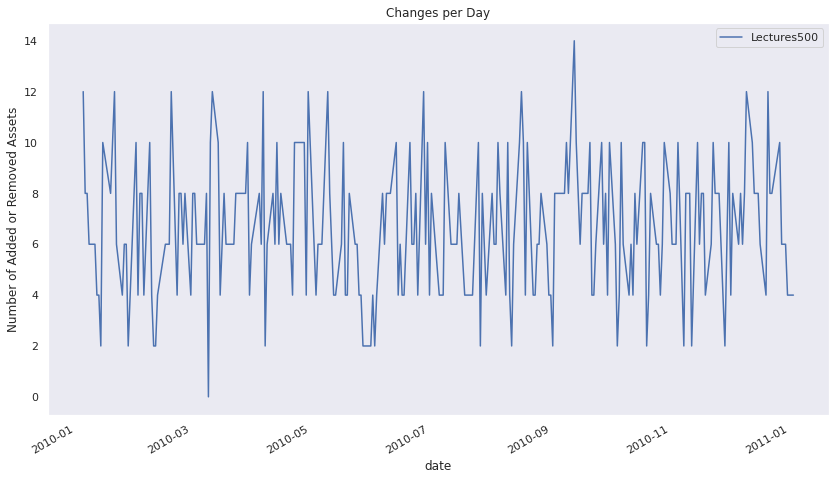

In [7]:
plot_daily_turnover(res)
print_daily_turnover_stats(res)

#### Smoothing

A good way to reduce turnover is through smoothing functions. Smoothing is the process of taking noisy data and aggregating it in order to analyze its underlying trends. When applied to universe selection, a good smoothing function prevents equities at the universe boundary from entering and exiting frequently.

One example of a potential smoothing function is a filter that finds equities that have passed the Lectures500 criteria for 16 or more days out of the past 21 days. We can use the `.at_least_n(...)` method on Filter for this purpose. This aggregation of many days of data lends a certain degree of flexibility to the edges of our universe. If, for example, Equity XYZ is very close to the boundary for inclusion, in a given month, it may flit in and out of the Lectures500 day after day. However, with the `at_least_n` filter, Equity XYZ is allowed to enter and exit the daily universe a maximum of 5 times before it is excluded from the smoothed universe.

Let's apply a smoothing function to our universe and see its effect on turnover.

      Lectures500 Smoothed
mean              3.388889
std               1.714583
25%               2.000000
50%               3.000000
75%               5.000000
min               0.000000
max              10.000000


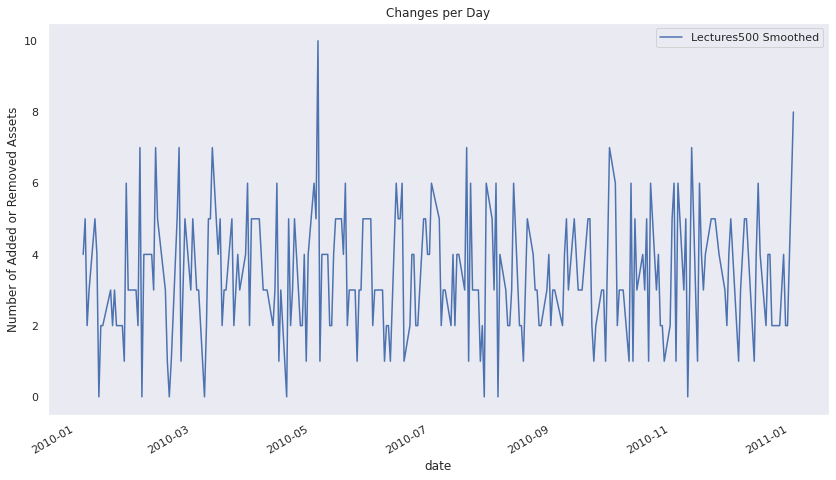

In [8]:
Lectures500 = Lectures500.at_least_n(16, window_length=21)

res_smoothed = run_pipeline(
    Pipeline(
        columns={
            'Lectures500 Smoothed' : Lectures500
        },
        initial_universe=common_stocks
    ), 
    start_date='2010-01-01',
    end_date='2011-01-01',
    bundle='usstock-learn-1d')
res_smoothed = res_smoothed.unstack().fillna(False).astype(int)

plot_daily_turnover(res_smoothed)
print_daily_turnover_stats(res_smoothed)

Looking at the metrics, we can see that the smoothed universe has a lower turnover than the original Lectures500. Since this is a good characteristic, we will add this logic to the universe.

NB: Smoothing can also be accomplished by downsampling.

---

**Next Lecture:** [The Capital Asset Pricing Model and Arbitrage Pricing Theory](Lecture30-CAPM-and-Arbitrage-Pricing-Theory.ipynb)

[Back to Introduction](Introduction.ipynb) 

---

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by QuantRocket LLC ("QuantRocket"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, the authors have not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information believed to be reliable at the time of publication. QuantRocket makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*